# K-Means Algorithm

(id, (v1, v2..., v58))

In [1]:
import math
from pyspark import SparkContext, SparkConf

In [2]:
MAX_ITER = 20
global_path = "/Users/wazenmaichen/wazenmai/nthu/CS/massive_data_analysis/HW3/hw3-kmeans-testcase/"

In [8]:
conf = SparkConf().setMaster("local").setAppName("kmeans")
sc = SparkContext(conf=conf)

In [43]:
NodeNum = 0
Dimension = 58

# (pid, [v0, v1..., v58])
def preprocess_data(data):
    global NodeNum
    data_list = []
    for d in data.splitlines():
        ele = d.split(' ')
        temp_list = []
        for e in ele:
            temp_list.append(float(e))
        data_list.append((NodeNum, temp_list))
        NodeNum += 1
    return data_list

# (dim, (pid, v_dim))
def align_dimension(data):
    global NodeNum
    data_list = []
    for line in data.splitlines():
        ele = line.split(' ')
        for d, v in enumerate(ele):
            data_list.append((d, (NodeNum, float(v))))
        NodeNum += 1
    return data_list

def align_centroid(data):
    # (cid, [v0, v1, ..., v58])
    data_list = []
    for d, ele in enumerate(data[1]):
        data_list.append((d, (data[0], ele)))
    return data_list


""" Compute Distance """
def compute_euclidean(x):
    # (dim, ((pid, pvalue), (cid, cvalue)) -> ((pid, cid), distance)
    return((x[1][0][0], x[1][1][0]), (x[1][0][1] - x[1][1][1]) ** 2)

def compute_manhattan(x):
    # (dim, ((pid, pvalue), (cid, cvalue)) -> ((pid, cid), distance)
    return ((x[1][0][0], x[1][1][0]), abs(x[1][0][1] - x[1][1][1]))


""" Find the centroid with smallest distance """
def find_closest(x, y):
    # (cid, distance)
    if x[1] <= y[1]:
        return x
    else:
        return y

def compute_centroid(x):
    # (cid, [v0, v1, ..., v58, ..., v0, v1..., v58, ...])
    cvalue = [0] * Dimension
    citizens_num = len(x[1]) // Dimension
    for n in range(citizens_num):
        for d in range(Dimension):
            cvalue[d] += x[1][d + n * Dimension]
    for d in range(Dimension):
        cvalue[d] /= citizens_num
    return (x[0], cvalue)    

In [49]:
def k_means(centroid, distFunc, cost_list):
    """
    centroid: initial centroid
    
    distFunc: Euclidean or Manhattan
    
    cost_list: record cost list
    """
    for iteration in range(MAX_ITER):
        print("iteration: ", iteration)

        # find centroid and closest_distance for each point
        pc_distance = points.join(centroid).map(distFunc).reduceByKey(lambda x, y: x + y) # ((pid, cid), distance)
        pc_distance = pc_distance.map(lambda x: (x[0][0], (x[0][1], x[1]))) # (pid, (cid, distance))
        
#         pc_distance = pc_distance.map(lambda x: (x[0][0], (x[0][1], math.sqrt(x[1])))) # (pid, (cid, distance))
        pc_distance = pc_distance.reduceByKey(find_closest) # (pid, (cid, closest_distance))

        # cost function
        cost = pc_distance.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)
        cost_list.append(cost)
        print("cost: ", cost)
        
        # match point and centroid
        pc = pc_distance.map(lambda x: (x[0], x[1][0])) # (pid, cid)

        # recompute the centroid by points
        temp_centroid = pc.join(points_value) # (pid, (cid, [v0, v1..., v58]))
        temp_centroid = temp_centroid.map(lambda x: (x[1][0], x[1][1])) # (cid, [v0, v1..., v58])
        temp_centroid = temp_centroid.reduceByKey(lambda x, y: x + y).map(compute_centroid) # (cid, [v0, v1..., v58])
        centroid = temp_centroid.flatMap(align_centroid)
    return temp_centroid.sortByKey()

In [50]:
points = sc.textFile(global_path + "data.txt").flatMap(align_dimension)       # (d, (id, v_d))
points_value = sc.textFile(global_path + "data.txt").flatMap(preprocess_data) # (pid, [v0, v1, ..., v58])
c1 = sc.textFile(global_path + "c1.txt").flatMap(align_dimension)             # (d, (id, v_d))
c2 = sc.textFile(global_path + "c2.txt").flatMap(align_dimension)             # (d, (id, v_d))

cost_c1_ec = []
cost_c2_ec = []
cost_c1_mh = []
cost_c2_mh = []

In [62]:
print("Euclidean - C1")
final_c1_ec = k_means(c1, compute_euclidean, cost_c1_ec)
print("Euclidean - C2")
final_c2_ec = k_means(c2, compute_euclidean, cost_c2_ec)
print("Manhattan - C1")
final_c1_mh = k_means(c1, compute_manhattan, cost_c1_mh)
print("Manhattan - C2")
final_c2_mh = k_means(c2, compute_manhattan, cost_c2_mh)

Manhattan - C1
iteration:  0


cost:  550117.1420000002
iteration:  1


cost:  465617.3485236672
iteration:  2


cost:  470902.29650127527
iteration:  3


cost:  483932.3931689977
iteration:  4


cost:  489207.57581724896
iteration:  5


cost:  487597.67386148946
iteration:  6


cost:  483507.3944688315
iteration:  7


cost:  475258.8666639479
iteration:  8


cost:  474863.62392036873
iteration:  9


cost:  457210.606910489
iteration:  10


cost:  447522.40673446015
iteration:  11


cost:  450872.48677093367
iteration:  12


cost:  451157.7926116736
iteration:  13


cost:  451922.28116581036
iteration:  14


cost:  451572.9468517024
iteration:  15


cost:  452744.14279976796
iteration:  16


cost:  453082.73028718366
iteration:  17


cost:  450583.67086029856
iteration:  18


cost:  450368.74931674165
iteration:  19


cost:  449011.363725519


Manhattan - C2
iteration:  0


cost:  1433739.3099999973
iteration:  1


cost:  1084488.77696488
iteration:  2


cost:  973431.714662042
iteration:  3


cost:  895934.5925630708
iteration:  4


cost:  865128.3352940821
iteration:  5


cost:  845846.6470313488
iteration:  6


cost:  827219.5827561263
iteration:  7


cost:  803590.3456011106
iteration:  8


cost:  756039.5172761207
iteration:  9


cost:  717332.9025432303
iteration:  10


cost:  694587.9252526881
iteration:  11


cost:  684444.5019967912
iteration:  12


cost:  674574.7475478556
iteration:  13


cost:  667409.4699160268
iteration:  14


cost:  663556.6278215034
iteration:  15


cost:  660162.7772287573
iteration:  16


cost:  656041.3222947128
iteration:  17


cost:  653036.7540731604
iteration:  18


cost:  651112.4262522731
iteration:  19


cost:  649689.0131843534


In [82]:
sc.stop()

# Report
## Cost Function

### Percentage improvement values

In [64]:
percentage_improvement_value_c1_ec = (cost_c1_ec[0] - cost_c1_ec[-1]) / cost_c1_ec[0] * 100
percentage_improvement_value_c2_ec = (cost_c2_ec[0] - cost_c2_ec[-1]) / cost_c2_ec[0] * 100
print("a. c1: ", percentage_improvement_value_c1_ec)
print("a. c2: ", percentage_improvement_value_c2_ec)

a. c1:  26.885383292516984
a. c2:  79.43775029159896


In [65]:
percentage_improvement_value_c1_mh = (cost_c1_mh[0] - cost_c1_mh[-1]) / cost_c1_mh[0] * 100
percentage_improvement_value_c2_mh = (cost_c2_mh[0] - cost_c2_mh[-1]) / cost_c2_mh[0] * 100
print("b. c1: ", percentage_improvement_value_c1_mh)
print("b. c2: ", percentage_improvement_value_c2_mh)

b. c1:  18.378954327236944
b. c2:  54.68569434813399


### Cost vs. Iteration Figure

In [16]:
import matplotlib.pyplot as plt

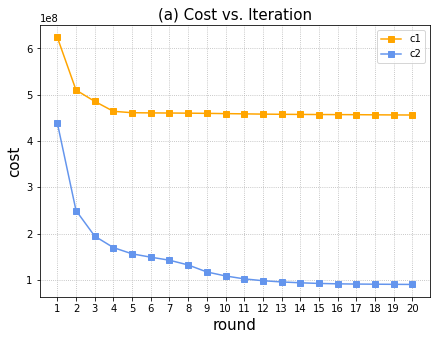

In [79]:
x_axis = list(range(1, MAX_ITER + 1))
plt.figure(figsize=(7,5))
plt.plot(x_axis, cost_c1_ec, 's-', color = 'orange', label="c1")
plt.plot(x_axis, cost_c2_ec, 's-', color = 'cornflowerblue', label="c2")
plt.title("(a) Cost vs. Iteration", fontsize=15)
plt.xticks(x_axis, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("round", fontsize=15)
plt.ylabel("cost", fontsize=15)
plt.legend(loc = "best", fontsize=10)
plt.grid(linestyle='dotted')
plt.savefig(global_path + "cost_a.png")
plt.show()


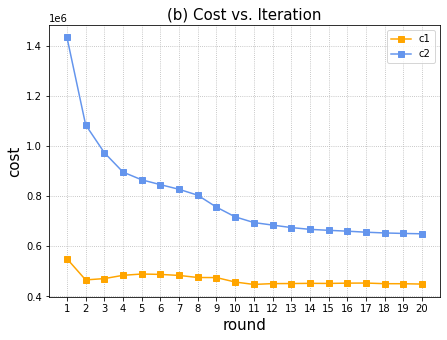

In [80]:
x_axis = list(range(1, MAX_ITER + 1))
plt.figure(figsize=(7,5))
plt.plot(x_axis, cost_c1_mh, 's-', color = 'orange', label="c1")
plt.plot(x_axis, cost_c2_mh, 's-', color = 'cornflowerblue', label="c2")
plt.title("(b) Cost vs. Iteration", fontsize=15)
plt.xticks(x_axis, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("round", fontsize=15)
plt.ylabel("cost", fontsize=15)
plt.legend(loc = "best", fontsize=10)
plt.grid(linestyle='dotted')
plt.savefig(global_path + "cost_b.png")
plt.show()

## Table

In [29]:
import csv
import pandas as pd

### Cost Table

In [76]:
df = pd.DataFrame(cost_c1_ec, columns=['C1'])
df.index = ['Round ' + str(j) for j in range(1, 21)]
df['C2'] = cost_c2_ec
df.to_csv(global_path + "a_cost_table.csv")
df

,C1,C2
Round 1,6.236603e+08,4.387478e+08
Round 2,5.098629e+08,2.498039e+08
Round 3,4.854807e+08,1.944948e+08
Round 4,4.639970e+08,1.698048e+08
Round 5,4.609693e+08,1.562957e+08
Round 6,4.605378e+08,1.490942e+08
Round 7,4.603131e+08,1.425085e+08
Round 8,4.600035e+08,1.323039e+08
Round 9,4.595705e+08,1.171710e+08
Round 10,4.590211e+08,1.085474e+08


In [78]:
df = pd.DataFrame(cost_c1_mh, columns=['C1'])
df.index = ['Round ' + str(j) for j in range(1, 21)]
df['C2'] = cost_c2_mh
df.to_csv(global_path + "b_cost_table.csv")
df

,C1,C2
Round 1,550117.142000,1.433739e+06
Round 2,465617.348524,1.084489e+06
Round 3,470902.296501,9.734317e+05
Round 4,483932.393169,8.959346e+05
Round 5,489207.575817,8.651283e+05
Round 6,487597.673861,8.458466e+05
Round 7,483507.394469,8.272196e+05
Round 8,475258.866664,8.035903e+05
Round 9,474863.623920,7.560395e+05
Round 10,457210.606910,7.173329e+05


### Centroid Value

In [68]:
# final_c1_ec: [(cid, [v0, v1, ..., v58]), ...]

def result_to_csv(final_centroid, distFunc, output_name):
    value_record = [[0] * 10 for k in range(11)]
    test_c = final_centroid.sortByKey().collect()
    for i in test_c:
        for j in test_c:
            if i[0] >= j[0]:
                continue
            distance = 0
            for d in range(Dimension):
                if distFunc == "euclidean":
                    distance += (i[1][d] - j[1][d]) ** 2
                else:
                    distance += abs(i[1][d] - j[1][d])
            if distFunc == "euclidean":
                distance = math.sqrt(distance)
            value_record[i[0] + 1][j[0]] = distance
    df = pd.DataFrame(value_record, columns = list(range(1, 11)))
    df = df.drop(labels=0, axis=0)
    df.to_csv(global_path + output_name)
    return df

In [61]:
""" Problem (a)"""
a_c1_ec_df = result_to_csv(final_c1_ec, "euclidean", "a_c1_ec.csv")
a_c2_ec_df = result_to_csv(final_c2_ec, "euclidean", "a_c2_ec.csv")
a_c1_mh_df = result_to_csv(final_c1_ec, "manhattan", "a_c1_mh.csv")
a_c2_mh_df = result_to_csv(final_c2_ec, "manhattan", "a_c2_mh.csv")

In [81]:
""" Problem (b)"""
b_c1_ec_df = result_to_csv(final_c1_mh, "euclidean", "b_c1_ec.csv")
b_c2_ec_df = result_to_csv(final_c2_mh, "euclidean", "b_c2_ec.csv")
b_c1_mh_df = result_to_csv(final_c1_mh, "manhattan", "b_c1_mh.csv")
b_c2_mh_df = result_to_csv(final_c2_mh, "manhattan", "b_c2_mh.csv")